In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-S", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-S", trust_remote_code=True).to(device)

def get_embedding_fp16(dna_seq):
    """
    Compute the mean-pooled embedding using mixed precision (FP16)
    """
    inputs = tokenizer(dna_seq, return_tensors='pt')["input_ids"].to(device)
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            hidden_states = model(inputs)[0] 
        embedding = torch.mean(hidden_states[0], dim=0)
    return embedding.cpu().numpy()



In [6]:
def get_embedding_chunked(dna_seq, chunk_size=512, overlap=0):
    """
    Compute the embedding for a long DNA sequence by splitting it into smaller chunks.
    
    Parameters:
      dna_seq (str): The input DNA sequence.
      chunk_size (int): Maximum chunk size (should be within model limits).
      overlap (int): Number of tokens to overlap between chunks (for smooth transitions).
    
    Returns:
      numpy.ndarray: The mean-pooled embedding over the sequence.
    """
    import torch.cuda.amp as amp
    emb_list = []
    step = chunk_size - overlap if overlap < chunk_size else 1

    for i in range(0, len(dna_seq), step):
        chunk = dna_seq[i : i + chunk_size]
        inputs = tokenizer(chunk, return_tensors='pt')["input_ids"].to(device)
        with torch.no_grad():
            with amp.autocast():
                hidden_states = model(inputs)[0]
            chunk_embedding = torch.mean(hidden_states[0], dim=0)
        emb_list.append(chunk_embedding)
    
    full_embedding = torch.mean(torch.stack(emb_list), dim=0)
    return full_embedding.cpu().numpy()



In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("./coronaviridae_sequences_with_genomes_final.csv")

# Use first 150 sequences only
embeddings = []

for i in range(150):
    seq = df["Genomic Sequence"].iloc[i]
    emb = get_embedding_chunked(seq)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)

labels = df["Organism"].iloc[:150]
labels_encoded = pd.Categorical(labels).codes

C:\Users\haris\AppData\Local\Temp\ipykernel_27604\3919283913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


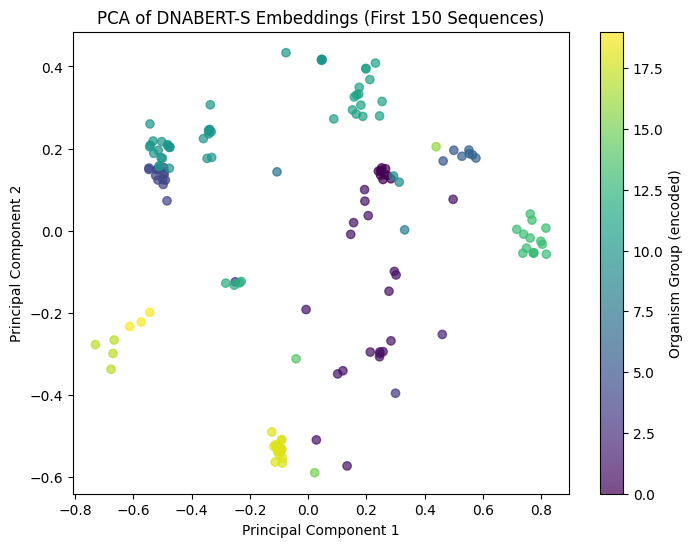

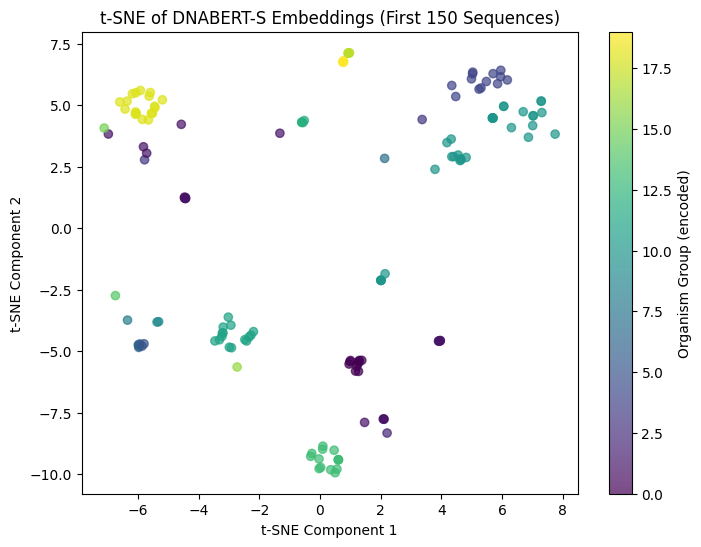

In [18]:

# PCA Visualization
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("PCA of DNABERT-S Embeddings (First 150 Sequences)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("t-SNE of DNABERT-S Embeddings (First 150 Sequences)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Determine the number of unique clusters in the first 150 labels
n_unique_clusters = len(np.unique(labels_encoded))
print(f"Number of unique organism groups in subset: {n_unique_clusters}")

kmeans = KMeans(n_clusters=n_unique_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Compute Silhouette Score
sil_score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score (subset): {sil_score:.3f}")

# Compute Adjusted Rand Index (ARI)
ari = adjusted_rand_score(labels_encoded, clusters)
print(f"Adjusted Rand Index (ARI, subset): {ari:.3f}")

Number of unique organism groups in subset: 20
Silhouette Score (subset): 0.468
Adjusted Rand Index (ARI, subset): 0.664


In [8]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("./BertDnaS_Run2.csv")

# Compute embeddings for each sequence
embeddings = []

# for i in range(150):
#     seq = df["Genomic Sequence"][i]
#     emb = get_embedding_chunked(seq)
#     embeddings.append(emb)

for seq in df["Genomic Sequence"]:
    emb = get_embedding_chunked(seq)
    embeddings.append(emb)

import numpy as np
embeddings = np.vstack(embeddings)


labels = df["GBSeq_organism"]
# labels = df["Organism"]

C:\Users\haris\AppData\Local\Temp\ipykernel_27604\3919283913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


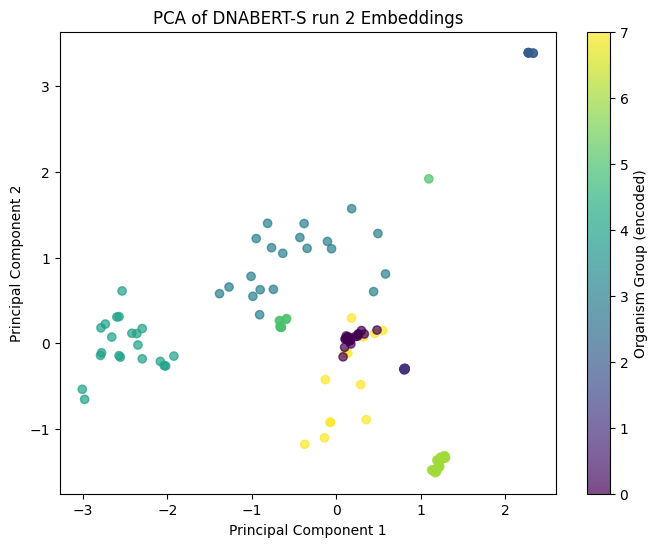

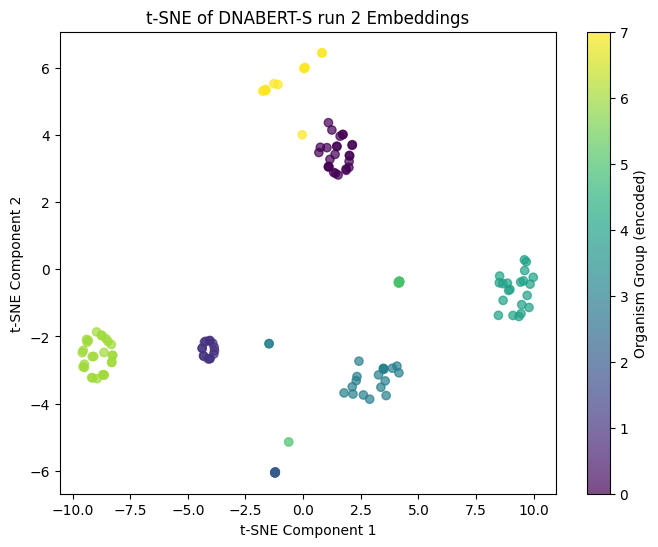

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert categorical labels to numeric codes for coloring
labels_encoded = pd.Categorical(labels).codes

# --- PCA Visualization ---
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], 
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("PCA of DNABERT-S run 2 Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

# --- t-SNE Visualization ---
# t-SNE may capture nonlinear relationships better.
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
                      c=labels_encoded, cmap='viridis', alpha=0.7)
plt.title("t-SNE of DNABERT-S run 2 Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Organism Group (encoded)")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Set number of clusters equal to the number of unique organisms
n_clusters = len(pd.unique(labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Silhouette score: higher is better (range from -1 to 1)
sil_score = silhouette_score(embeddings, clusters)
print(f"Silhouette Score: {sil_score:.3f}")


true_labels = labels_encoded
ari = adjusted_rand_score(true_labels, clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Silhouette Score: 0.545
Adjusted Rand Index (ARI): 0.817


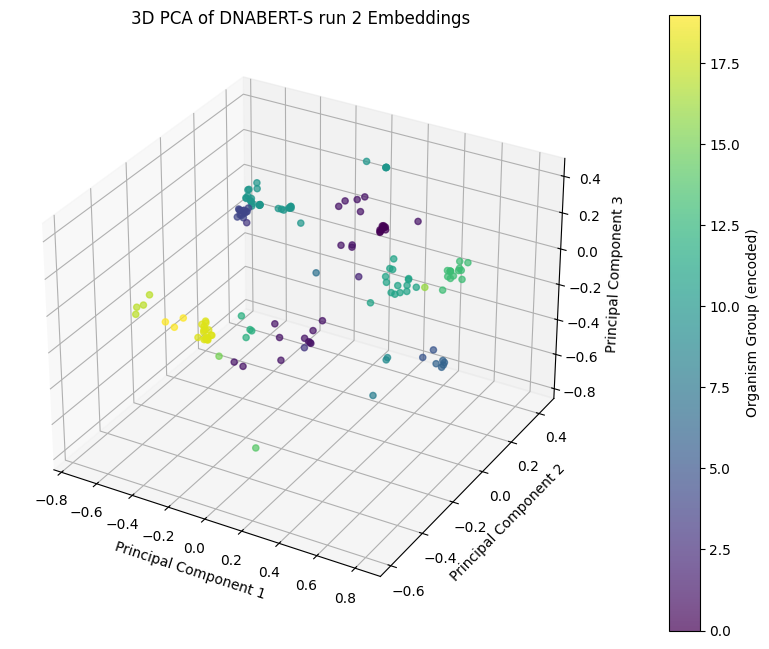

In [20]:
pca3d = PCA(n_components=3)
embeddings_pca3d = pca3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_pca3d[:, 0], embeddings_pca3d[:, 1], embeddings_pca3d[:, 2],
                      c=labels_encoded, cmap='viridis', alpha=0.7)
ax.set_title("3D PCA of DNABERT-S run 2 Embeddings")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

cbar = fig.colorbar(scatter, ax=ax, pad = 0.1)
cbar.set_label("Organism Group (encoded)")
plt.show()